# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [24]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [25]:
# load in the data
#azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\Daniel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [26]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [30]:
filtered_customers = customers.filter(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'BALLRAUM', 
                                       #'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 
                                       'D19_BANKEN_ANZ_24',
                          'D19_BANKEN_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_DATUM',
                           'D19_VERSAND_ONLINE_QUOTE_12', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
                          'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR',
                          'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN',
                          'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
                          'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
                          'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
                           'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
                          'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_FLAG', 'TITEL_KZ', 
                           'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
                           'ONLINE_AFFINITAET', 'REGIOTYP'])

"""AGER_TYP	best-ager typology
ALTERSKATEGORIE_GROB - age classification through prename analysis 
ANREDE_KZ - gender
BALLRAUM - distance to next urban centre 
CAMEO_DEUG_2015 - class
D19_BANKEN_ANZ_12 - transaction activity BANKS in the last 12 months
D19_BANKEN_ANZ_24 -transaction activity BANKS in the last 24 months
D19_BANKEN_DATUM - actuality of the last transaction for the segment banks TOTAL
     
D19_VERSAND_OFFLINE_DATUM	actuality of the last transaction for the segment mail-order OFFLINE
D19_VERSAND_ONLINE_DATUM	actuality of the last transaction for the segment mail-order ONLINE
D19_VERSAND_DATUM	actuality of the last transaction for the segment mail-order TOTAL
D19_VERSAND_ONLINE_QUOTE_12	amount of online transactions within all transactions in the segment mail-order 
D19_VOLLSORTIMENT_RZ	transactional activity based on the product group COMPLETE MAIL-ORDER OFFERS
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
FINANZ_MINIMALIST	financial typology: low financial interest
FINANZ_SPARER	financial typology: money saver
FINANZ_VORSORGER	financial typology: be prepared
FINANZ_ANLEGER	financial typology: investor
FINANZ_UNAUFFAELLIGER	financial typology: unremarkable
FINANZ_HAUSBAUER	financial typology: main focus is the own house
FINANZTYP	best descirbing financial type for the peron
GEBURTSJAHR	year of birth
GFK_URLAUBERTYP	vacation habits
GREEN_AVANTGARDE	the environmental sustainability is the dominating movement in the youth of these consumers
HEALTH_TYP	health typology
LP_LEBENSPHASE_FEIN	lifestage fine
LP_LEBENSPHASE_GROB	lifestage rough
LP_FAMILIE_FEIN	family type fine
LP_FAMILIE_GROB	family type rough
LP_STATUS_FEIN	social status fine 
LP_STATUS_GROB	social status rough
NATIONALITAET_KZ	nationaltity
PRAEGENDE_JUGENDJAHRE	dominating movement in the person's youth (avantgarde or mainstream)
RETOURTYP_BK_S	return type
SEMIO_SOZ	affinity indicating in what way the person is social minded
SEMIO_FAM	affinity indicating in what way the person is familiar minded
SEMIO_REL	affinity indicating in what way the person is religious
SEMIO_MAT	affinity indicating in what way the person is material minded
SEMIO_VERT	affinity indicating in what way the person is dreamily
SEMIO_LUST	affinity indicating in what way the person is sensual minded
SEMIO_ERL	affinity indicating in what way the person is eventful orientated
SEMIO_KULT	affinity indicating in what way the person is cultural minded
SEMIO_RAT	affinity indicating in what way the person is of a rational mind
SEMIO_KRIT	affinity indicating in what way the person is critical minded
SEMIO_DOM	affinity indicating in what way the person is dominant minded
SEMIO_KAEM	affinity indicating in what way the person is of a fightfull attitude
SEMIO_PFLICHT	affinity indicating in what way the person is dutyfull traditional minded
SEMIO_TRADV	affinity indicating in what way the person is traditional minded
SHOPPER_TYP	shopping typology
SOHO_FLAG	small office/home office flag
TITEL_KZ	flag whether this person holds an academic title
VERS_TYP	insurance typology 
ZABEOTYP	typification of energy consumers
GEBAEUDETYP_RASTER	industrial areas
KKK	purchasing power
MOBI_REGIO	moving patterns
ONLINE_AFFINITAET	online affinity
REGIOTYP	AZ neighbourhood typology"""
filtered_customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,BALLRAUM,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_DATUM,D19_VERSAND_ONLINE_QUOTE_12,...,SEMIO_TRADV,SHOPPER_TYP,TITEL_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP
0,2,4,1,3.0,0,10,9,10,9,0.0,...,1,3,0.0,1,3,4.0,1.0,4.0,3.0,1.0
1,-1,4,1,NaN,1,6,10,9,9,0.0,...,1,3,0.0,1,3,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,7.0,0,10,10,10,10,0.0,...,1,1,0.0,2,3,3.0,3.0,3.0,1.0,7.0
3,1,4,1,7.0,0,10,6,10,6,0.0,...,4,0,0.0,1,1,4.0,3.0,4.0,2.0,6.0
4,-1,3,1,3.0,2,3,8,1,1,10.0,...,4,1,0.0,2,1,3.0,4.0,3.0,5.0,7.0


In [ ]:
def data_inspection(dataframe):
    dataframe.isnull.sum()
    dataframe.dtypes

In [63]:
def preprocessing (dataframe):
    dataframe = dataframe.copy()
    dataframe.replace(-1, float('NaN'), inplace=True)
    dataframe.replace(0, float('NaN'), inplace=True)
    
    new_list = []

    for i in range(0, dataframe.shape[1]):     
        if (dataframe.iloc[:, i].dtypes == 'object'):
            dataframe.iloc[:, i] = pd.Categorical(dataframe.iloc[:, i])
            dataframe.iloc[:, i] = dataframe.iloc[:, i].cat.codes 
            dataframe.iloc[:, i] = dataframe.iloc[:, i].astype('object')

            new_list.append(dataframe.columns[i])
    for i in dataframe:
        dataframe[i] = dataframe[i].fillna(dataframe[i].median())
    
    dataframe.drop('LNR', axis=1, inplace=True)
    
    return dataframe
            
#filtered_customers.replace(NaN, float('NaN'), inplace=True)

In [28]:
preprocessing(customers)

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,1.0,10.0,13.0,14.0,15.0,16.0,10.0,1.0,1.0,...,2.0,6.0,9.0,7.0,3,1,0,1.0,1,4
1,2.0,9.0,11.0,13.0,14.0,15.0,16.0,11.0,1.0,1.0,...,3.0,5.0,9.0,3.0,3,2,1,1.0,1,4
2,2.0,1.0,6.0,13.0,14.0,15.0,16.0,11.0,1.0,1.0,...,11.0,6.0,9.0,2.0,3,1,0,1.0,2,4
3,1.0,1.0,8.0,13.0,14.0,15.0,16.0,8.0,1.0,1.0,...,2.0,5.0,9.0,7.0,1,0,0,1.0,1,4
4,2.0,1.0,20.0,13.0,14.0,15.0,16.0,14.0,7.0,1.0,...,4.0,2.0,9.0,3.0,1,2,0,1.0,1,3


In [23]:
"""filtered_customers['GEBURTSJAHR'].describe()
plt.figure(figsize=(5,6))
plt.hist(customers['GEBURTSJAHR'])
df = filtered_customers[filtered_customers['GEBURTSJAHR'] > 1800]['GEBURTSJAHR']
plt.figure(figsize=(5,6))
plt.hist(df)
customers.drop(customers[customers['GEBURTSJAHR'] < 1850].index, inplace=True)

#from sklearn.impute import KNNImputer # Importing K Nearest Neighbors Algorithm
# K Nearest Neighbours algorithm is used to replace values with its nearest neighbours - or most similar row data
#df_final = pd.DataFrame(KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean').fit(filtered_customers).transform(filtered_customers), columns = filtered_customers.columns)"""

"filtered_customers['GEBURTSJAHR'].describe()\nplt.figure(figsize=(5,6))\nplt.hist(customers['GEBURTSJAHR'])\ndf = filtered_customers[filtered_customers['GEBURTSJAHR'] > 1800]['GEBURTSJAHR']\nplt.figure(figsize=(5,6))\nplt.hist(df)\ncustomers.drop(customers[customers['GEBURTSJAHR'] < 1850].index, inplace=True)"

In [9]:
for i in filtered_customers:
    print(filtered_customers[i].unique())

[  9626   9628 143872 ... 148813 148852 148883]
[ 2. nan  1.  3.]
[ 1.  9.  3.  7.  5.  2. nan  4.  6.  8.]
[10. 11.  6.  8. 20.  5. 14. 21. 15. 17. nan 19.  9. 12. 13. 18.  7. 16.
  4.  2.  3.]
[nan  8. 12.  9.  7. 13. 17. 14. 18. 11. 16.  6. 10. 15.  5.  3.  4.  2.]
[nan  9. 17. 10. 14. 13. 12. 11. 16. 18. 15.  7.  5.  8.  6.  3.  2.  4.]
[nan 13. 16. 18. 15. 17. 14. 12. 11. 10.  8.  7.  9.  6.  5.]
[nan 18. 12. 16. 13. 17. 11. 14. 15. 10.  8.]
[10. nan  8. 14.  9.  4. 13.  6. 12. 19. 17. 15. 11. 16.  7. 18. 21. 25.
 20. 24.  5.  2. 22.  3. 23.]
[  1.  nan   7.  74.   9.  17.  12.  29.   2.  45.  10.  14.  15.  55.
   6.   5. 108.   3.  25.  18.   4.  11.  19.   8.  26.  43.  63.  47.
  16.  31.  57.  37.  13.  22.  20.  23.  27. 305.  52.  21.  34.  46.
  24.  33.  51. 523. 104. 101.  59.  44.  38.  61.  69.  28.  48.  40.
  39. 145. 107.  32.  76. 117.  87.  84.  41. 286.  92. 222. 119.  71.
  36. 344.  42.  82. 160.  35.  67.  30. 112.  85.  93.  58.  60. 221.
  77. 102. 140.  79.

[ 3. nan  2.  1.  4.  9.]
[ 2. nan  1.  3.  9.]
[ 2. nan  1.  4.  3.  9.]
[ 4. nan  3.  5.  2.  1.  9.]
[ 3. nan  4.  5.  1.  2.  9.]
[ 4. nan  3.  1.  2.  5.  9.]
[ 2. nan  1.  3.  9.]
[ 2. nan  3.  4.  1.  5.  6.]
[ 4. nan  2.  3.  1.  9.]
[ 1. nan  2.  3.  9.]
[ 1. nan  3.  2.  9.]
[ 2. nan  4.  1.  3.  9.]
[ 3. nan  2.  4.  1.  5.  9.]
[ 2. nan  4.  3.  5.  1.  9.]
[ 3. nan  4.  2.  5.  1.  9.]
[ 3. nan  1.  4.  2.  9.]
[ 1. nan  9.]
[nan  3.  1.  2.  9.]
[ 1. nan  2.  3.  9.]
[ 2. nan  1.  3.  9.]
[ 4. nan  3.  2.  5.  1.  9.]
[ 3. nan  4.  1.  2.  5.  9.]
[ 2. nan  3.  1.  4.  5.  9.]
[ 3. nan  2.  1.  4.  5.  9.]
[ 4. nan  3.  5.  2.  1.  9.]
[ 2. nan  3.  4.  5.  1.  9.]
[ 3. nan  2.  4.  1.  5.  9.]
[ 1. nan  3.  2.  4.  5.]
[ 2. nan  3.  4.  5.  1.]
[ 5. nan  2.  3.  1.  4.]
[ 3. nan  4.  2.  1.  5.]
[ 3. nan  1.  2.  4.]
[ 3. nan  4.  2.  1.]
[ 1. nan  3.  2.]
[nan  1.  2.]
[1201.   nan  433. ...   77.   13.   34.]
[ 4. nan  2.  3.  1.  5.]
[ 4. nan  2.  3.  1.  5.]
[ 1. nan

# PCA 

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_df = pca.fit(filtered_customers).transform(filtered_customers)
pca.explained_variance_ratio_

array([0.74950751, 0.24521073])

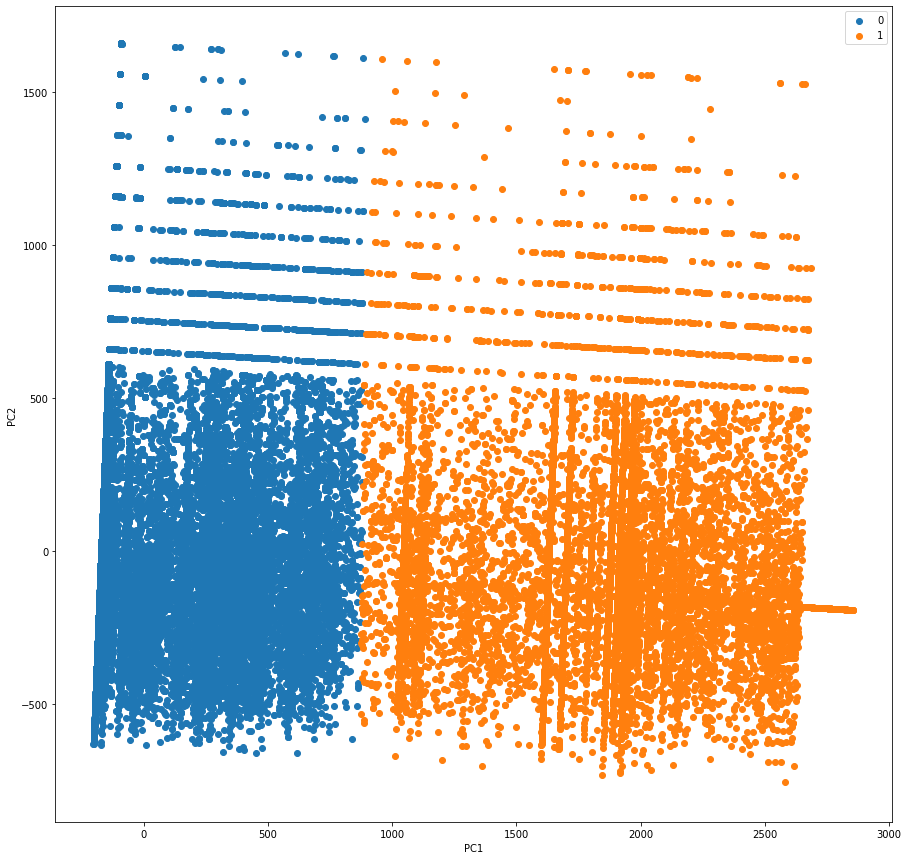

In [13]:
from sklearn.cluster import KMeans
model2 = KMeans(n_clusters = 2, init = "k-means++")
y2 = model2.fit_predict(X_df)
plt.figure(figsize=(15,15))
label2 = model2.fit_predict(X_df)
uniq = np.unique(label2)
for i in uniq:
  plt.scatter(X_df[label2 == i , 0] , X_df[label2 == i , 1] , label = i)
plt.xlabel([])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

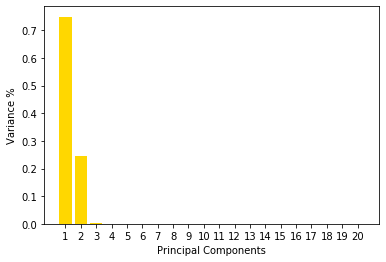

In [14]:
from sklearn.preprocessing import StandardScaler
std_wine = StandardScaler().fit_transform(filtered_customers)

pca = PCA(n_components=20)
principalComponents = pca.fit_transform(filtered_customers)

PC = range(1, pca.n_components_+1)
plt.bar(PC, pca.explained_variance_ratio_, color='gold')
plt.xlabel('Principal Components')
plt.ylabel('Variance %')
plt.xticks(PC)

# Putting components in a dataframe for later
PCA_components = pd.DataFrame(principalComponents)


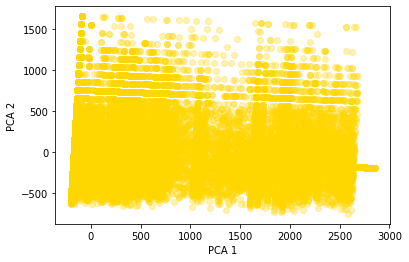

In [44]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.3, color='gold')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

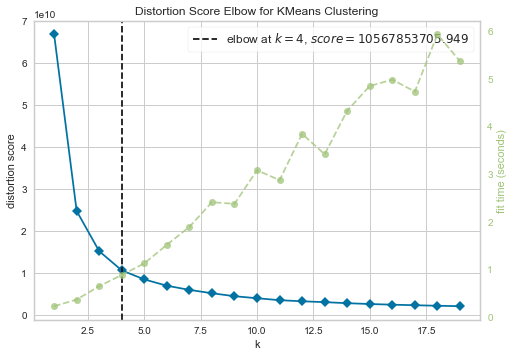

In [16]:
from sklearn.cluster import KMeans # Importing K-Means algorithm 
from sklearn.impute import KNNImputer # Importing K Nearest Neighbors Algorithm
from sklearn.linear_model import LinearRegression # Importing Linear Regression model 
from sklearn.metrics import mean_squared_error # Evaluation metric 
from sklearn.model_selection import train_test_split # Preprocessing for training and testing data splits 

from yellowbrick.cluster import KElbowVisualizer # Importing Elbow Method Library

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20)) # Loop through model to find ideal number of clusters within the data

visualizer.fit(PCA_components)
visualizer.show()

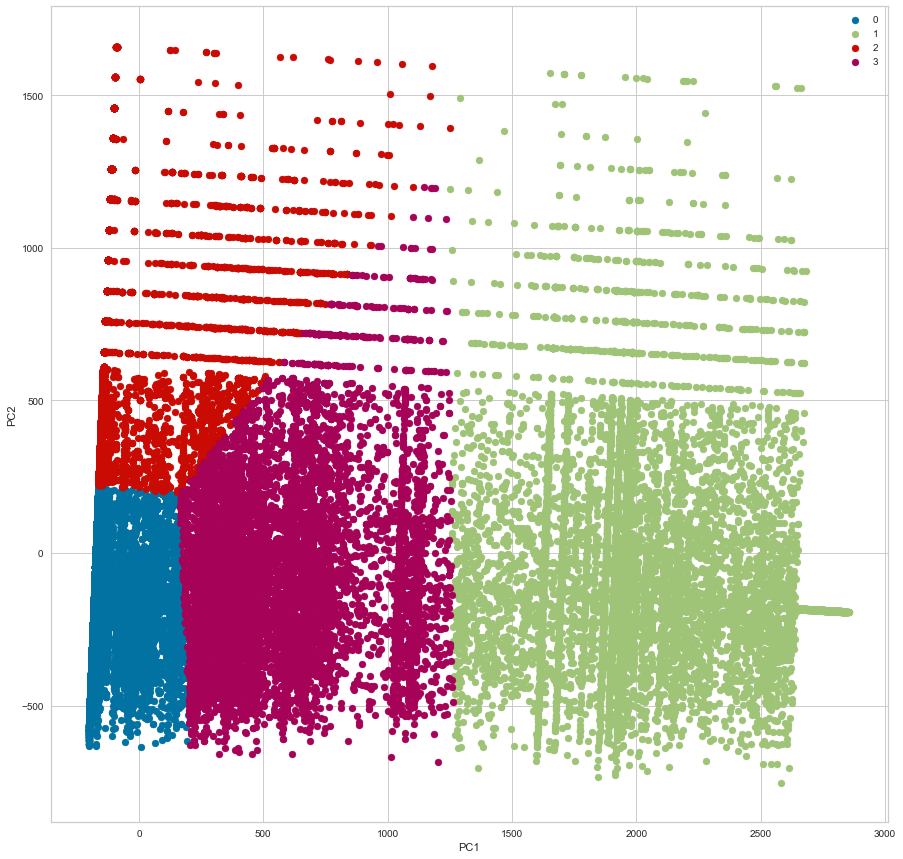

In [19]:
from sklearn.cluster import KMeans
model2 = KMeans(n_clusters = 4, init = "k-means++")
y2 = model2.fit_predict(X_df)
plt.figure(figsize=(15,15))
label2 = model2.fit_predict(X_df)
uniq = np.unique(label2)
for i in uniq:
  plt.scatter(X_df[label2 == i , 0] , X_df[label2 == i , 1] , label = i)
plt.xlabel([])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [35]:
df_final.to_csv('df_final1.csv')

In [37]:
df_final.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,BALLRAUM,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_DATUM,D19_VERSAND_ONLINE_QUOTE_12,...,SEMIO_TRADV,SHOPPER_TYP,TITEL_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP
0,2.0,4.0,1.0,3.0,1.0,10.0,9.0,10.0,9.0,9.0,...,1.0,3.0,1.0,1.0,3.0,4.0,1.0,4.0,3.0,1.0
1,2.0,4.0,1.0,5.8,1.0,6.0,10.0,9.0,9.0,10.0,...,1.0,3.0,1.0,1.0,3.0,4.2,1.6,3.8,3.2,2.8
2,2.0,4.0,2.0,7.0,1.4,10.0,10.0,10.0,10.0,10.0,...,1.0,1.0,1.0,2.0,3.0,3.0,3.0,3.0,1.0,7.0
3,1.0,4.0,1.0,7.0,2.0,10.0,6.0,10.0,6.0,5.8,...,4.0,2.0,1.0,1.0,1.0,4.0,3.0,4.0,2.0,6.0
4,2.0,3.0,1.0,3.0,2.0,3.0,8.0,1.0,1.0,10.0,...,4.0,1.0,1.0,2.0,1.0,3.0,4.0,3.0,5.0,7.0


In [49]:
# Fitting location data using five clusters
kmeans = KMeans(n_clusters=2, random_state=0).fit(filtered_customers)

filtered_customers['cluster'] = kmeans.labels_ # Adding extra column to the location dataframe to allocate data to separate groups
filtered_customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB,cluster
0,2.0,1.0,10.0,13.0,14.0,15.0,16.0,10.0,1.0,1.0,...,6.0,9.0,7.0,3,1,0,1.0,1,4,0
1,2.0,9.0,11.0,13.0,14.0,15.0,16.0,11.0,1.0,1.0,...,5.0,9.0,3.0,3,2,1,1.0,1,4,0
2,2.0,1.0,6.0,13.0,14.0,15.0,16.0,11.0,1.0,1.0,...,6.0,9.0,2.0,3,1,0,1.0,2,4,0
3,1.0,1.0,8.0,13.0,14.0,15.0,16.0,8.0,1.0,1.0,...,5.0,9.0,7.0,1,0,0,1.0,1,4,0
4,2.0,1.0,20.0,13.0,14.0,15.0,16.0,14.0,7.0,1.0,...,2.0,9.0,3.0,1,2,0,1.0,1,3,0


In [50]:
array = kmeans.cluster_centers_
array = array.astype(int)
array

array([[   1,    1,   13,   12,   13,   14,   15,   11,    3,    1,    1,
           2,    3,    1,    2,    4,   12,    7,   17,    3,    4,    2,
           2,    4,    4,    4,    4,    1,    1,    9,    5,    5,    6,
           9,    9,    9,    5,    5,    5,    5,    6,    5,    5,    4,
           4,    5,    5,    2,    2,    6,    8,    7,    9,    6,    5,
           5,    3,    4,    6,    5,   15,    6,    5,    5,    5,    5,
           3,    5,    1,    6,    1,    1,    9,    5,    9,    9,    9,
           5,    5,    2,    2,    7,    8,    7,    9,    5,    1,    1,
           9,    9,    9,    9,    5,    5,    5,    1,   54, 1998,    3,
          37,    2,    2,    3,    2,    2,    4,    4,    3,    2,    3,
        1948,   23,    6,    1,    1,    1,    2,    4,    1,    2,    3,
           3,    1,    2,    1,    1,    1,    3,    1,    2,    2,    3,
           2,    2,    3,    3,    2,    3,    2,    2,    2,    2,    3,
           3,    3,    2,    2,    2, 

In [49]:
df = pd.DataFrame(array, columns=['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'BALLRAUM', 
                                       #'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 
                                       'D19_BANKEN_ANZ_24',
                          'D19_BANKEN_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_DATUM',
                           'D19_VERSAND_ONLINE_QUOTE_12', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
                          'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR',
                          'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN',
                          'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
                          'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
                          'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
                           'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
                          'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_FLAG', 'TITEL_KZ', 
                           'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
                           'ONLINE_AFFINITAET', 'REGIOTYP'])
df.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,BALLRAUM,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_DATUM,D19_VERSAND_ONLINE_QUOTE_12,...,SHOPPER_TYP,SOHO_FLAG,TITEL_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP
0,1,2,1,4,1,9,8,7,6,9,...,1,1,1,3,3,2,3,3,4,4
1,1,1,1,3,1,9,9,9,9,9,...,2,1,1,2,3,1,4,2,3,0
2,1,3,1,4,1,8,7,6,5,8,...,2,1,1,2,3,2,3,3,3,1
3,1,2,1,4,1,8,8,5,5,9,...,1,1,1,2,3,2,3,4,3,3
4,1,3,1,4,1,9,8,8,7,9,...,2,1,1,2,3,2,3,2,3,0


In [ ]:
# Extra resources. Not useful now

#feature Importance
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define the model
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

#XGBoost

# xgboost for feature importance on a classification problem
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from matplotlib import pyplot
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=1)
# define the model
model = XGBClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [84]:
train_csv = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
train_csv.head()

C:\Users\Daniel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3325: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [85]:
X = train_csv[:]
X = preprocessing(X)
X.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,1.0,8.0,13.0,14.0,15.0,15.0,8.0,15.0,1.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,1.0,2,4
1,1.0,4.0,13.0,13.0,14.0,15.0,15.0,13.0,1.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,1.0,2,3
2,1.0,1.0,9.0,13.0,14.0,15.0,15.0,7.0,2.0,1.0,...,6.0,4.0,2.0,6.0,9.0,2.0,3,1.0,1,4
3,2.0,1.0,6.0,13.0,14.0,15.0,15.0,6.0,4.0,1.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,1.0,2,4
4,2.0,1.0,9.0,13.0,14.0,15.0,15.0,9.0,53.0,1.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,1.0,1,3


In [86]:
y = train_csv.pop('RESPONSE')
print(y.count())
print(y.nunique())
print(y.head())

42962
2
0    0
1    0
2    0
3    0
4    0
Name: RESPONSE, dtype: int64


In [87]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train)

SVC()

In [88]:
# Add pipeline for grid search to optimize model
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)
print ("Accuracy : {:.2f}%".format(accuracy_score(y_test, y_pred)*100))

Accuracy : 98.70%
